In [20]:
import pandas as pd
import numpy as np
import json

#df = pd.read_parquet("hf://datasets/Laz4rz/wikipedia_science_chunked_small_rag_512/wikipedia_science_chunked_small_rag.parquet")

In [ ]:
df=pd.read_csv("../data/raw/wikipedia_science_chunked_small_rag_512.csv")
df_sample = df.sample(n=16000, random_state=3531)
df_sample.to_csv("../data/raw/wikipedia_m.csv", index=False)

In [1]:
#import nltk
# Tokenization (required for word/sentence tokenization)
# nltk.download('punkt')

# # Stopwords (useful for removing common stopwords)
# nltk.download('stopwords')

# # Lemmatization with WordNet
# nltk.download('wordnet')

# # Parts of Speech Tagging, if needed
# nltk.download('averaged_perceptron_tagger')
# nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /Users/ngumus/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ngumus/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /Users/ngumus/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/ngumus/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [69]:
df_sample = pd.read_csv("../data/processed/wikipedia_m.csv")
df_sample.head(10)

,text,category,url,title
0,think of lampedusa is a collection of serial p...,Literature&Languages,https://en.wikipedia.org/wiki?curid=55818555,Think of Lampedusa
1,michel degraff degraff holds a phd in computer...,Social_sciences,https://en.wikipedia.org/wiki?curid=44947261,Michel DeGraff
2,experimenters regress in science experimenters...,Psychology,https://en.wikipedia.org/wiki?curid=1608493,Experimenter's regress
3,the grand baltimore maryland it was sperry who...,Civil_engineering,https://en.wikipedia.org/wiki?curid=18162747,"The Grand (Baltimore, Maryland)"
4,rio de janeiro has the second largest municipa...,History&Archaeology,https://en.wikipedia.org/wiki?curid=25936,Rio de Janeiro
5,environmental personhood the main point of the...,Humanities,https://en.wikipedia.org/wiki?curid=54993244,Environmental personhood
6,loudspeaker some horn designs not only fold th...,Engineering&Technology,https://en.wikipedia.org/wiki?curid=45871,Loudspeaker
7,water scarcity the international resource pane...,Civil_engineering,https://en.wikipedia.org/wiki?curid=15380061,Water scarcity
8,entschdigungseinrichtung deutscher banken in g...,Business&Economics,https://en.wikipedia.org/wiki?curid=36430324,Entschädigungseinrichtung deutscher Banken
9,rehabilitation and reintegration of child sold...,History&Archaeology,https://en.wikipedia.org/wiki?curid=56635096,Rehabilitation and reintegration of child so...


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import string
from nltk.tokenize import word_tokenize
import nltk

# Extract text and labels
X = df_sample['text']
df_sample['category_encoded'] = df_sample['category'].astype('category').cat.codes
y = df_sample['category_encoded']
# Preprocess text: lowercasing, removing punctuation, and tokenizing

def preprocess_text(text):
    # Lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Tokenize
    tokens = word_tokenize(text)
    # Remove stopwords
    stopwords = set(nltk.corpus.stopwords.words('english'))
    tokens = [word for word in tokens if word not in stopwords]
    # Stem the tokens
    stemmer = nltk.PorterStemmer()
    tokens = [stemmer.stem(word) for word in tokens]
    return ' '.join(tokens)

# Apply preprocessing to the text data
X = X.apply(preprocess_text)

# Initialize TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000,ngram_range=(1,6))

# Fit and transform the training data, transform the testing data
X = tfidf_vectorizer.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=412)




In [67]:
# Save vectorizer
def save(vectorizer:TfidfVectorizer,path:str):
    import joblib
    joblib.dump(vectorizer, path)

['./tfidf_vectorizer.joblib']

In [68]:
# Load vectorizer
vectorizer = joblib.load("./tfidf_vectorizer.joblib")
vectorizer.transform(df_sample['text'].apply(preprocess_text))

<16000x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 1134227 stored elements in Compressed Sparse Row format>

In [ ]:
def save(df_sample):
    corpus = [preprocess_text(x) for x in df_sample['text'].to_list()]
    tfidf_vectorizer = TfidfVectorizer(max_features=5000,ngram_range=(1,6))
    tf_idf_matrix = tfidf_vectorizer.fit_transform(corpus).toarray()
    df_sample["embeddings"] = tf_idf_matrix.tolist()
    df_sample["embeddings"] = df_sample["embeddings"].apply(lambda x: json.dumps(x))
    df_sample.to_csv("./test.csv", index=False)
    
def load():
    df_new=pd.read_csv("./test.csv")
    df_new["embeddings"] = df_new["embeddings"].apply(lambda x: np.array(json.loads(x))) 
    X_embed = np.stack(np.array(df_new["embeddings"]))
    y_embed = df_new['category_encoded']
    X_train, X_test, y_train, y_test = train_test_split(X_embed, y_embed, test_size=0.2, random_state=412)
    return X_train, X_test, y_train, y_test


In [65]:
df_sample["embeddings"] = X.toarray().tolist()
df_sample["embeddings"] = df_sample["embeddings"].apply(lambda x: json.dumps(x))
df_sample.to_csv("./test.csv", index=False)
df_new=pd.read_csv("./test.csv",converters={'embeddings': lambda x: np.array(json.loads(x))})
X_embed = np.stack(np.array(df_new["embeddings"]))
X_embed.shape

(16000, 5000)

In [58]:
# Initialize and train the XGBoost model
xgb_model = XGBClassifier(use_label_encoder=False, 
                          eval_metric='mlogloss', 
                          objective='multi:softmax', 
                          num_class=len(df_sample['category_encoded'].unique()),
                          learning_rate=0.3, 
                          #max_depth=5, 
                          n_estimators=10,
                          #gemma=0.1
                          )

# Train the XGBoost model with early stopping on the validation set
res= xgb_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=True)

# Predict on the test set
y_pred = xgb_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

/Users/ngumus/projects/Master-Thesis/.venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:20:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-mlogloss:2.51507
[1]	validation_0-mlogloss:2.38742
[2]	validation_0-mlogloss:2.30649
[3]	validation_0-mlogloss:2.24623
[4]	validation_0-mlogloss:2.20264
[5]	validation_0-mlogloss:2.16495
[6]	validation_0-mlogloss:2.13460
[7]	validation_0-mlogloss:2.11121
[8]	validation_0-mlogloss:2.09011
[9]	validation_0-mlogloss:2.07484
Accuracy: 0.3690625


In [194]:
# Extract epoch-wise metrics
def visualize_model(xgb_model):
    from matplotlib import pyplot as plt
    results = xgb_model.evals_result_  # Get the evaluation results during training

    # Print results keys
    print("Keys in evals_result_:", results.keys())
    # Accessing specific metrics
    validation_loss = results['validation_0']['mlogloss']  # Epoch-wise loss on validation set
    epochs = range(1, len(validation_loss) + 1)  # Epoch numbers
    # Plot the loss over epochs
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, validation_loss, label='Validation Loss', marker='o')
    plt.title('Validation Loss Across Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Log Loss')
    plt.legend()
    plt.grid()
    plt.show()

Keys in evals_result_: dict_keys(['validation_0'])


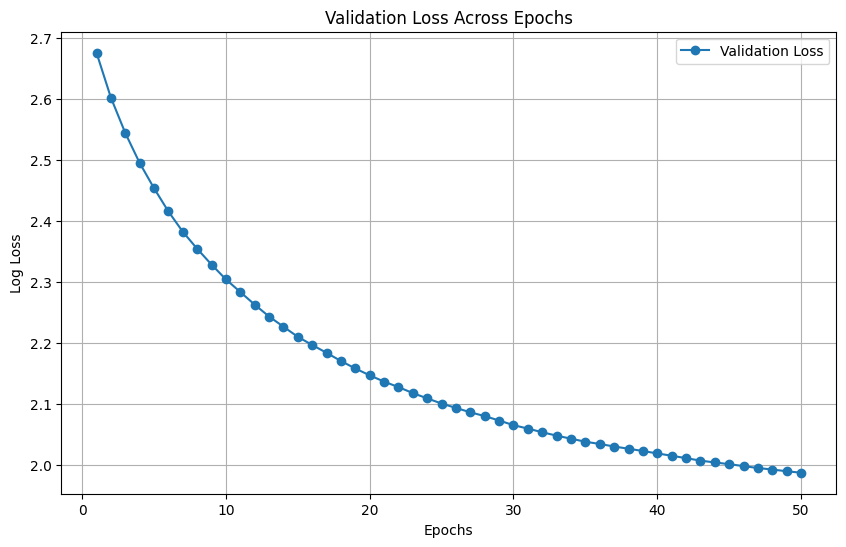

In [195]:
visualize_model(xgb_model)

In [188]:
from sklearn.ensemble import RandomForestClassifier

# Initialize and train the Random Forest model
rf_model = RandomForestClassifier(n_estimators=300, random_state=42,criterion="log_loss")
rf_model.fit(X_train, y_train)

# Predict on the test set
y_pred_rf = rf_model.predict(X_test)

# Calculate accuracy
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Accuracy: {accuracy_rf}")

Random Forest Accuracy: 0.3759375


In [174]:
X_test

<1200x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 84965 stored elements in Compressed Sparse Row format>

Input dimensions: 5000
Output dimensions: 16
SimpleNN(
  (fc1): Linear(in_features=5000, out_features=128, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=32, bias=True)
  (fc5): Linear(in_features=32, out_features=16, bias=True)
)
Epoch 1/20, Train Loss: 2.1665, Train Accuracy: 0.2744, Validation Accuracy: 0.3331
Epoch 2/20, Train Loss: 1.7046, Train Accuracy: 0.4214, Validation Accuracy: 0.3669
Epoch 3/20, Train Loss: 1.4196, Train Accuracy: 0.5136, Validation Accuracy: 0.3500
Epoch 4/20, Train Loss: 1.1776, Train Accuracy: 0.6044, Validation Accuracy: 0.3350
Epoch 5/20, Train Loss: 0.9698, Train Accuracy: 0.6830, Validation Accuracy: 0.3375
Epoch 6/20, Train Loss: 0.8179, Train Accuracy: 0.7346, Validation Accuracy: 0.3369
Epoch 7/20, Train Loss: 0.7217, Train Accuracy: 0.7714, Validation Accura

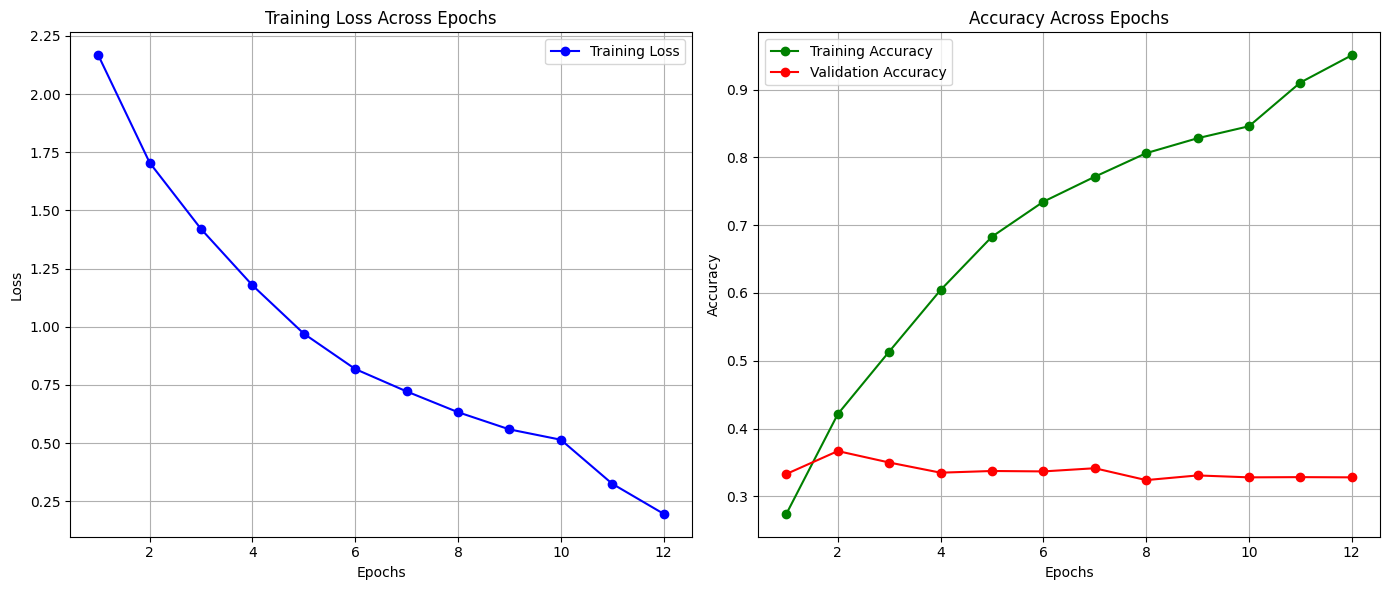

In [199]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

# Example dataset preprocessing (replace with your actual TF-IDF and labels)
# Assuming X_train_tfidf, X_test_tfidf, y_train, y_test are preprocessed
X_train_tensor = torch.tensor(X_train.toarray(), dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.toarray(), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

# Create DataLoader for training and testing
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)  # Shuffle during training
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


# Neural network with dropout for regularization
class SimpleNN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)  # Dropout to prevent overfitting
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 32)
        self.fc5 = nn.Linear(32, output_dim)
        
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        out = self.dropout(out)
        out = self.fc4(out)
        out = self.relu(out)
        out = self.fc5(out)
        return out


# Initialize the model, loss function, optimizer, and learning rate scheduler
input_dim = X_train.shape[1]
output_dim = len(y_train.unique())  # Number of classes
print("Input dimensions:", input_dim)
print("Output dimensions:", output_dim)
model = SimpleNN(input_dim, output_dim)
# Xavier initialization function
def initialize_weights(layer):
    if isinstance(layer, nn.Linear):
        nn.init.xavier_uniform_(layer.weight)  # Xavier initialization (uniform)
        nn.init.zeros_(layer.bias)  # Bias initialized to zero

# Apply Xavier initialization to the model
model.apply(initialize_weights)

# Print model to verify initialization
print(model) 

criterion = nn.CrossEntropyLoss()  # For multi-class classification
optimizer = optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-4)  # Added weight decay
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)  # Reduce LR every 5 epochs

# Early stopping configuration
early_stopping_patience = 10
best_validation_acc = 0
epochs_no_improve = 0
best_model_state = None

# Track metrics for visualization
train_losses = []
train_accuracies = []
val_accuracies = []

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    # Training phase
    model.train()
    epoch_loss = 0
    correct = 0
    total = 0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()  # Reset gradients
        outputs = model(X_batch)  # Forward pass
        loss = criterion(outputs, y_batch)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

        epoch_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()
    
    avg_train_loss = epoch_loss / len(train_loader)
    train_accuracy = correct / total
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)

    # Validation phase
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)  # Forward pass
            _, predicted = torch.max(outputs.data, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()

    val_accuracy = correct / total
    val_accuracies.append(val_accuracy)

    # Check for best validation accuracy
    if val_accuracy > best_validation_acc:
        best_validation_acc = val_accuracy
        epochs_no_improve = 0
        best_model_state = model.state_dict()  # Save the best model
    else:
        epochs_no_improve += 1

    # Print metrics
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, "
          f"Train Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    # Early stopping
    if epochs_no_improve >= early_stopping_patience:
        print("Early stopping triggered!")
        break

    # Step the learning rate scheduler
    scheduler.step()

# Load the best model state
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f"Best validation accuracy achieved: {best_validation_acc:.4f}")

# Save the final best model to disk (optional)
torch.save(best_model_state, "best_model.pth")

# --- Visualization of Metrics ---
epochs = range(1, len(train_losses) + 1)

# Plot Training Loss
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Training Loss', marker='o', color='blue')
plt.title('Training Loss Across Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

# Plot Accuracy (Training vs. Validation)
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Training Accuracy', marker='o', color='green')
plt.plot(epochs, val_accuracies, label='Validation Accuracy', marker='o', color='red')
plt.title('Accuracy Across Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

In [219]:
import pandas as pd

In [ ]:
import ast

df2= pd.read_csv("../data/embeddings/tfidf_wikipedia_m_embeddings.csv")
df2["embeddings"] = df2["embeddings"].apply(ast.literal_eval).astype(np.ndarray)
df2["embeddings"] 

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x1042af5e0>>
Traceback (most recent call last):
  File "/Users/ngumus/projects/Master-Thesis/.venv/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


In [228]:
df2.iloc[0]["embeddings"].toarray()

AttributeError: 'str' object has no attribute 'toarray'